In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
# import statsmodels.api as sm
from tqdm import tqdm
# from multiprocessing.dummy import Pool
import dask.dataframe as dd

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_columns', 500)

In [2]:
#In[] 1,227,297,915 size, 7675it * 10000
crsp_df = pd.read_csv("crsp_d.csv",header=0,
    parse_dates = ['date','DCLRDT','RCRDDT'],
    dtype={
        "PERMNO": str,
        "PRC": np.float64,
        "VOL": np.float64,
        "SHROUT": np.float64,
        "DIVAMT": np.float64,
        "SHRCD":str,
        "DISTCD":str,
        "COMNAM": str,
        "TICKER": str,
        'CUSIP': str,
        "BID": np.float64,
        "ASK": np.float64}, chunksize=100000)
#Data Preprocessing
#In[]
d = {}
one = False
def insert(i,x):
    if str(x)[-1].isdigit() == False:
        return
    x = float(x)
    if i not in d:
        d[i] = [x]
    else:
        d[i].append(x)
    return
cache = []
cache_ddate = set()
for c in tqdm(crsp_df):
    c = c[(c.SHRCD.isin(('10','11'))) ]
    c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
    if not one:
         cusip = c.head(1).reset_index().iloc[0].CUSIP
         one = True
    count = 0
    # c['dt'] = 0
    lastDivDate = None
    for row in c.itertuples():
        if row.CUSIP != cusip:
            cusip = row.CUSIP
            count = 0
            lastDivDate = None
            for row2 in cache:
                if row2[0] in cache_ddate:
                    count = 0
                    insert(count, row2[1])
                    cache_ddate.remove(row2[0])
                    count += 1
                    lastDivDate = True
                elif lastDivDate is not None:
                    insert(count, row2[1])
                    count += 1
            cache = list()
            cache_ddate = set()
        else:
            cache.append((row.date, row.RET))
            if pd.isna(row.RCRDDT) == False:
                cache_ddate.add(row.RCRDDT)
for row2 in cache:
    if row2[0] in cache_ddate:
        count = 0
        insert(count, row2[1])
        cache_ddate.remove(row2[0])
        count += 1
        lastDivDate = True
    elif lastDivDate is not None:
        insert(count, row2[1])
        count += 1        

819it [56:53,  4.17s/it]


In [3]:
#In[] 1,227,297,915 size, 7675it * 10000
crsp_df = pd.read_csv("crsp_d_rev2.csv",header=0,
    parse_dates = ['date','DCLRDT','RCRDDT'],
    dtype={
        "PERMNO": str,
        "PRC": np.float64,
        "VOL": np.float64,
        "SHROUT": np.float64,
        "DIVAMT": np.float64,
        "SHRCD":str,
        "DISTCD":str,
        "COMNAM": str,
        "TICKER": str,
        'CUSIP': str,
        "BID": np.float64,
        "ASK": np.float64}, chunksize=100000)
#Data Preprocessing
#In[]
def insert(i,x):
    if str(x)[-1].isdigit() == False:
        return
    x = float(x)
    if i not in d:
        d[i] = [x]
    else:
        d[i].append(x)
    return
one = False
cache = []
cache_ddate = set()
for c in tqdm(crsp_df):
    c = c[(c.SHRCD.isin(('10','11'))) ]
    c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
    if not one:
         cusip = c.head(1).reset_index().iloc[0].CUSIP
         one = True
    count = 0
    # c['dt'] = 0
    lastDivDate = None
    for row in c.itertuples():
        if row.CUSIP != cusip:
            cusip = row.CUSIP
            count = 0
            lastDivDate = None
            for row2 in cache:
                if row2[0] in cache_ddate:
                    count = 0
                    # insert(count, row.RET)
                    cache_ddate.remove(row2[0])
                    count += 1
                    lastDivDate = True
                elif lastDivDate is not None:
                    insert(count * -1, row2[1])
                    count += 1
            cache = list()
            cache_ddate = set()
        else:
            cache.append((row.date, row.RET))
            if pd.isna(row.RCRDDT) == False:
                cache_ddate.add(row.RCRDDT)
for row2 in cache:
    if row2[0] in cache_ddate:
        count = 0
        # insert(count, row.RET)
        cache_ddate.remove(row2[0])
        count += 1
        lastDivDate = True
    elif lastDivDate is not None:
        insert(count, row2[1])
        count += 1        

723it [09:45,  1.03it/s]/Users/ptakchun/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
819it [11:19,  1.21it/s]


In [4]:
x = range(-30, 61, 1)
dlist = [ 100*sum(d[key])/len(d[key]) for key in x ]
print(dlist)

[-0.42774218207921055, -0.42741019664098034, -0.42768367822271436, -0.4273916681582388, -0.42732621914869673, -0.4275908162353853, -0.42675096802975404, -0.4257428524765557, -0.4245914018691736, -0.42460679297872556, -0.424321999644417, -0.4243188620628586, -0.4239949828726817, -0.4225253289279741, -0.42161700032433225, -0.4210643065499981, -0.4205182776698003, -0.4210197839079225, -0.42149594184986927, -0.4212981350747267, -0.4208793049716407, -0.4208704403810093, -0.4208218692138256, -0.42067385862860385, -0.4206138493170925, -0.42056578383299825, -0.42041591956554875, -0.42067291856200756, -0.4206840399002614, -0.4208190995747297, -0.10212808641974977, -0.102274569127281, -0.10210489748772407, -0.10317327536398996, -0.1039935533273579, -0.10454333448953286, -0.10434361880529346, -0.10440710526315441, -0.10434212901359192, -0.10464085318206455, -0.1043505717511471, -0.10519181894529235, -0.10571436724996806, -0.10578679961737714, -0.10689726790219914, -0.10868443838319125, -0.1103235

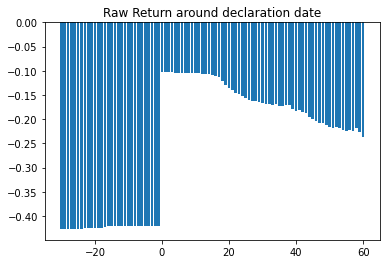

In [5]:
plt.bar(x,dlist)
plt.title('Raw Return around ex-dividend date')
plt.show()

In [6]:
sum(d[0])

-35.40576499999885

In [7]:
import pickle
filename = 'RCRDDT_Figure2.pkl'
with open(filename,'wb') as f:
     pickle.dump(dlist, f)

In [8]:
with open(filename,'rb') as f:
     a = pickle.load(f)

a == dlist

True